In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts.models import NBEATSModel, TCNModel, RNNModel, TransformerModel
from darts import TimeSeries
from darts.metrics import mae, mse, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from pytorch_lightning import Trainer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
custom_palette = sns.color_palette("coolwarm", n_colors=10)
sns.set_palette(custom_palette)

c:\Users\nice\anaconda3\envs\tens\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv(r"C:\Users\nice\Desktop\sales-forecasting-project (1)\sales-forecasting-project\Milestone1\retail_store_inventory_cleaned.csv")

In [3]:
df

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality,Sales,year,month,dayofweek
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Winter,4234.50,2022,1,5
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Winter,9431.50,2022,1,5
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Winter,1809.35,2022,1,5
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Winter,1985.92,2022,1,5
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Winter,1030.96,2022,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72422,2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter,569.84,2024,1,0
72423,2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Winter,4201.07,2024,1,0
72424,2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter,389.96,2024,1,0
72425,2024-01-01,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Winter,14008.96,2024,1,0


In [4]:
# تحويل عمود Date إلى DatetimeIndex
df['Date'] = pd.to_datetime(df['Date'])  # تأكد من أن العمود من النوع datetime
df.set_index('Date', inplace=True)  # تعيين العمود كفهرس

In [5]:
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [6]:
key_columns = ['Units Sold', 'Demand Forecast', 'Inventory Level', 'Price', 'Discount', 'Competitor Pricing', 'Holiday/Promotion']
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers(df, key_columns)

In [7]:
df['Units Sold Differenced'] = df['Units Sold'] - df['Units Sold'].shift(1)
data_differenced = df['Units Sold Differenced'].dropna()

adf_result_diff = adfuller(data_differenced)
print("\nADF Statistic (Differenced):", adf_result_diff[0])
print("p-value (Differenced):", adf_result_diff[1])
print("Critical Values (Differenced):")
for key, value in adf_result_diff[4].items():
    print(f"\t{key}: {value}")


ADF Statistic (Differenced): -58.0155161656123
p-value (Differenced): 0.0
Critical Values (Differenced):
	1%: -3.4304415362808345
	5%: -2.8615804574238224
	10%: -2.5667915341020495


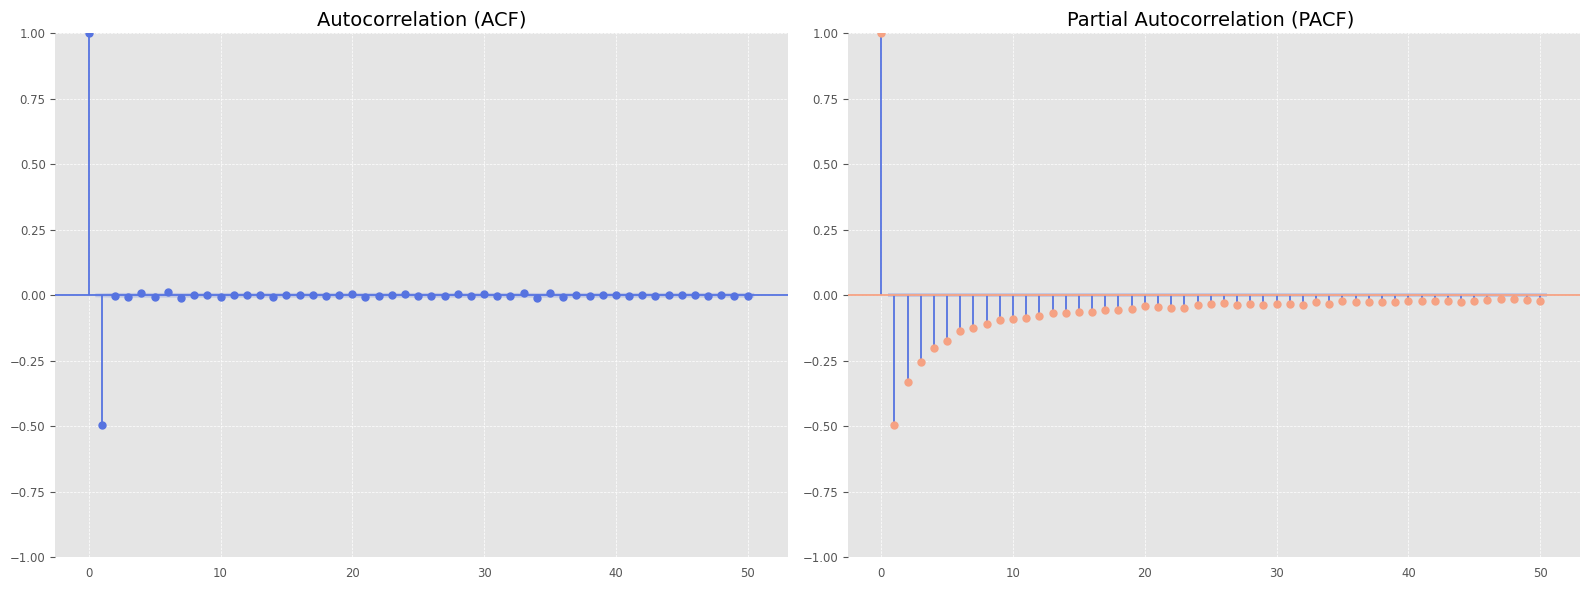

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(data_differenced, ax=axes[0], lags=50, color=custom_palette[0])
axes[0].set_title('Autocorrelation (ACF)', fontsize=14)
axes[0].grid(True, linestyle='--', linewidth=0.5)

plot_pacf(data_differenced, ax=axes[1], lags=50, color=custom_palette[7])
axes[1].set_title('Partial Autocorrelation (PACF) ', fontsize=14)
axes[1].grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [9]:
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Week'] = df.index.isocalendar().week
df['Year'] = df.index.year

In [10]:
df['Lag_1'] = df['Units Sold'].shift(1)
df['Lag_7'] = df['Units Sold'].shift(7)
df['Lag_30'] = df['Units Sold'].shift(30)

In [11]:
df['Rolling_Mean_7'] = df['Units Sold'].rolling(window=7).mean()
df['Rolling_Std_7'] = df['Units Sold'].rolling(window=7).std()
df['Rolling_Mean_30'] = df['Units Sold'].rolling(window=30).mean()
df['Rolling_Std_30'] = df['Units Sold'].rolling(window=30).std()

In [59]:
data = df.dropna()

In [60]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [61]:
train

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Sales,year,...,Day,Week,Year,Lag_1,Lag_7,Lag_30,Rolling_Mean_7,Rolling_Std_7,Rolling_Mean_30,Rolling_Std_30
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,67,13,33,7.44,34.62,0,1,33.98,450.06,2022,...,1,52,2022,126.0,63.0,127.0,139.428571,142.694145,136.700000,107.632885
2022-01-01,281,25,136,37.27,19.56,5,1,19.01,484.00,2022,...,1,52,2022,13.0,156.0,150.0,120.714286,148.625608,132.533333,109.503498
2022-01-01,389,283,177,299.70,57.78,20,0,58.50,16331.74,2022,...,1,52,2022,25.0,250.0,65.0,125.428571,153.841755,139.800000,112.070606
2022-01-01,465,359,77,370.36,91.28,20,0,90.85,32749.52,2022,...,1,52,2022,283.0,393.0,61.0,120.571429,144.221886,149.733333,117.900289
2022-01-01,197,129,94,148.55,59.90,15,1,55.23,7712.10,2022,...,1,52,2022,359.0,29.0,14.0,134.857143,138.477951,153.566667,115.172938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-08,343,275,178,283.43,70.14,5,1,70.56,19283.50,2023,...,8,32,2023,144.0,59.0,102.0,129.857143,81.423642,119.000000,75.980488
2023-08-08,334,79,71,74.30,35.03,15,1,35.37,2752.37,2023,...,8,32,2023,275.0,168.0,305.0,117.142857,81.423642,111.466667,67.650080
2023-08-08,405,274,86,273.25,21.35,10,0,17.09,5839.90,2023,...,8,32,2023,79.0,31.0,198.0,151.857143,89.932250,114.000000,72.267702


In [62]:
train = train[~train.index.duplicated(keep='first')]
test = test[~test.index.duplicated(keep='first')]
train = train.asfreq('D')  
test = test.asfreq('D')

def fill_missing(series):
    return series.fillna(method='ffill').fillna(method='bfill')

train['Units Sold'] = fill_missing(train['Units Sold'])
test['Units Sold'] = fill_missing(test['Units Sold'])

In [63]:
train

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Sales,year,...,Day,Week,Year,Lag_1,Lag_7,Lag_30,Rolling_Mean_7,Rolling_Std_7,Rolling_Mean_30,Rolling_Std_30
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,67,13,33,7.44,34.62,0,1,33.98,450.06,2022,...,1,52,2022,126.0,63.0,127.0,139.428571,142.694145,136.700000,107.632885
2022-01-02,116,81,104,92.94,27.95,10,0,30.89,2253.95,2022,...,2,52,2022,101.0,171.0,46.0,146.714286,121.815043,127.100000,100.324766
2022-01-03,154,5,189,5.36,62.70,20,0,58.22,293.50,2022,...,3,1,2022,183.0,241.0,206.0,171.000000,131.940643,137.733333,105.742346
2022-01-04,85,58,193,52.87,77.88,15,1,75.99,4502.04,2022,...,4,1,2022,91.0,263.0,143.0,79.142857,68.884997,119.566667,99.399814
2022-01-05,238,147,37,150.27,28.46,20,1,29.40,4163.62,2022,...,5,1,2022,54.0,11.0,240.0,166.142857,71.917612,139.566667,89.099589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04,65,55,26,65.00,18.70,0,0,15.52,1028.50,2023,...,4,31,2023,111.0,8.0,77.0,69.285714,52.829014,111.266667,92.710500
2023-08-05,492,23,31,28.72,77.33,10,1,76.69,1768.59,2023,...,5,31,2023,48.0,55.0,89.0,140.428571,122.864230,147.333333,118.051518
2023-08-06,201,187,22,181.55,21.51,5,1,23.63,4017.37,2023,...,6,31,2023,71.0,56.0,206.0,123.142857,100.620456,115.966667,110.792594


In [65]:
test

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Sales,year,...,Day,Week,Year,Lag_1,Lag_7,Lag_30,Rolling_Mean_7,Rolling_Std_7,Rolling_Mean_30,Rolling_Std_30
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-08,463,384,186,375.38,89.94,0,0,90.63,34536.96,2023,...,8,32,2023,36.0,148.0,163.0,198.714286,122.215267,120.533333,89.707084
2023-08-09,57,32,96,38.19,87.66,5,1,89.01,2800.12,2023,...,9,32,2023,413.0,59.0,90.0,166.000000,133.444121,131.300000,105.365096
2023-08-10,356,176,172,170.73,89.55,15,0,86.89,15745.80,2023,...,10,32,2023,53.0,313.0,71.0,190.857143,124.636042,139.800000,120.214578
2023-08-11,422,90,149,96.63,20.54,10,1,21.62,1838.60,2023,...,11,32,2023,49.0,41.0,59.0,76.857143,62.041461,100.900000,96.417680
2023-08-12,140,46,163,38.95,34.72,5,0,37.80,1592.12,2023,...,12,32,2023,33.0,5.0,235.0,76.142857,75.893409,123.133333,105.516050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,104,67,64,78.15,77.61,0,1,78.00,5199.87,2023,...,28,52,2023,138.0,50.0,44.0,180.285714,131.005998,143.700000,105.063577
2023-12-29,224,168,35,184.45,14.01,15,1,18.51,2338.68,2023,...,29,52,2023,56.0,222.0,121.0,163.142857,112.554326,134.233333,89.490775
2023-12-30,208,30,167,20.66,57.00,10,0,54.92,1700.00,2023,...,30,52,2023,268.0,198.0,241.0,154.857143,101.032055,149.066667,98.967056


16:44:05 - cmdstanpy - INFO - Chain [1] start processing
16:44:06 - cmdstanpy - INFO - Chain [1] done processing


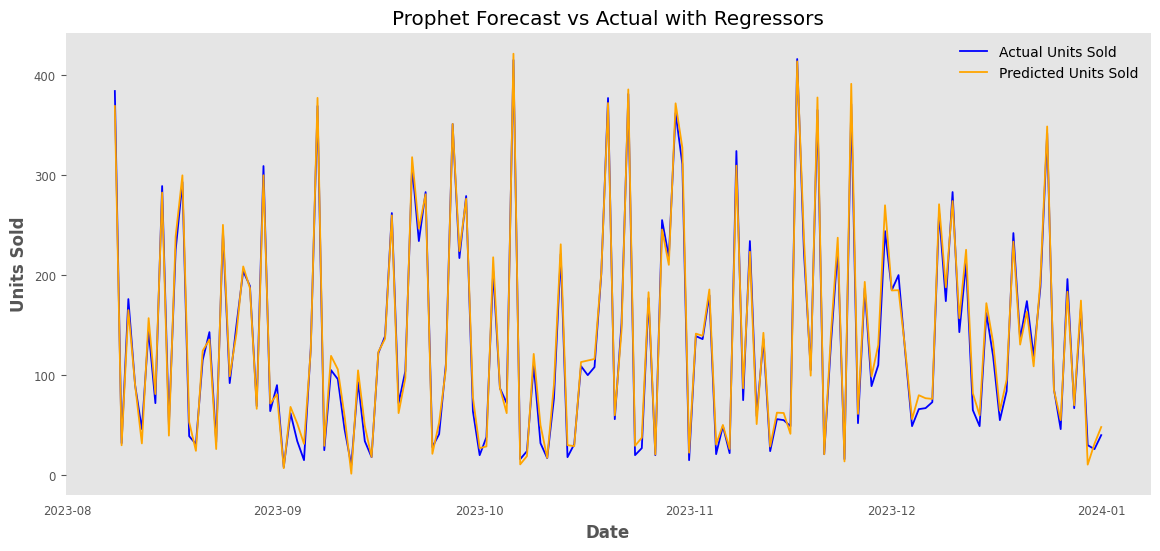

Prophet MAE with regressors: 8.306062461406176


In [91]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# نجهز بيانات التدريب والاختبار
train_df = train.copy()
test_df = test.copy()

# Ensure the 'Date' column exists in train and test DataFrames
if 'Date' not in train_df.columns:
    train_df = train_df.reset_index().rename(columns={"index": "Date"})
if 'Date' not in test_df.columns:
    test_df = test_df.reset_index().rename(columns={"index": "Date"})

# إعادة تسمية الأعمدة الأساسية لـ Prophet
train_df = train_df.rename(columns={"Date": "ds", "Units Sold": "y"})
test_df = test_df.rename(columns={"Date": "ds", "Units Sold": "y"})

# اختيار أهم الـ features كـ extra regressors (اختار اللي أنت شايفه مؤثر فعلاً)
regressors = [
    'Inventory Level',"Rolling_Mean_7","Rolling_Std_7","Rolling_Mean_30","month","Seasonality_Summer","Seasonality_Winter",
    "Seasonality_Spring","Holiday/Promotion","Demand Forecast"
]


# نضيفهم للنموذج

model = Prophet(
    daily_seasonality=True,              # إضافة العطلات
    seasonality_prior_scale=15,       # ضبط تأثير الموسمية
    holidays_prior_scale=10,          # ضبط تأثير العطلات
    changepoint_prior_scale=0.1,      # زيادة مرونة النموذج في التغيرات
    changepoint_range=0.95,           # تحديد نطاق التغيرات في البيانات
    n_changepoints=50,                # زيادة عدد نقاط التحول
    yearly_seasonality=True,          # تفعيل الموسمية السنوية
    weekly_seasonality=True           # تفعيل الموسمية الأسبوعية
)      

for reg in regressors:
    model.add_regressor(reg)
# تدريب النموذج
model.fit(train_df[['ds', 'y'] + regressors])

# دمج بيانات test مع train عشان نبني future
future = pd.concat([train_df[['ds'] + regressors], test_df[['ds'] + regressors]], axis=0)


# توقع
forecast = model.predict(future)

# استخراج التوقعات الخاصة بـ test فقط
forecast_test = forecast.iloc[-len(test_df):]

# رسم مقارنة بين التوقع والفعلية
plt.figure(figsize=(14, 6))
plt.plot(test_df['ds'], test_df['y'].values, label='Actual Units Sold', color='blue')
plt.plot(test_df['ds'], forecast_test['yhat'].values, label='Predicted Units Sold', color='orange')
plt.legend()
plt.title("Prophet Forecast vs Actual with Regressors")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid()
plt.show()

# حساب MAE
mae = mean_absolute_error(test_df['y'], forecast_test['yhat'])
print(f"Prophet MAE with regressors: {mae}")


In [92]:
forecast[['yhat']]


,yhat
0,5.905958
1,90.503011
2,1.633936
3,50.156469
4,145.152739
...,...
727,69.832407
728,174.515422
729,10.536004
730,31.310224


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(r"C:\Users\nice\Desktop\sales-forecasting-project (1)\sales-forecasting-project\notebooks\forecast_results1.csv", index=False)


In [95]:
from prophet import Prophet
import mlflow
import mlflow.pyfunc
import tempfile
import joblib
import mlflow
from mlflow import MlflowClient

# Set experiment name (optional)


client = MlflowClient()

model_name = "prophet-timeseries"
alias_name = "prod" 
mlflow.set_experiment("prophet-timeseries-forecasting")

with mlflow.start_run(run_name="Prophet with Regressors"):
    # Always create a new Prophet object
    model = Prophet(
        daily_seasonality=True,
        seasonality_prior_scale=15,
        holidays_prior_scale=10,
        changepoint_prior_scale=0.1,
        changepoint_range=0.95,
        n_changepoints=50,
        yearly_seasonality=True,
        weekly_seasonality=True
    )
    for reg in regressors:
        model.add_regressor(reg)

    mlflow.log_param("model_type", "Prophet")
    mlflow.log_param("seasonality_prior_scale", 15)
    mlflow.log_param("holidays_prior_scale", 10)
    mlflow.log_param("changepoint_prior_scale", 0.1)
    mlflow.log_param("changepoint_range", 0.95)
    mlflow.log_param("n_changepoints", 50)
    mlflow.log_param("yearly_seasonality", True)
    mlflow.log_param("weekly_seasonality", True)
    mlflow.log_param("daily_seasonality", True)
    mlflow.log_param("regressors", regressors)

    # Fit model
    model.fit(train_df[['ds', 'y'] + regressors])

    # Predict
    future = pd.concat([train_df[['ds'] + regressors], test_df[['ds'] + regressors]], axis=0)
    forecast = model.predict(future)
    forecast_test = forecast.iloc[-len(test_df):]

    # Calculate MAE
    mae = mean_absolute_error(test_df['y'], forecast_test['yhat'])
    mlflow.log_metric("mae", mae)

    # Log model
    with tempfile.TemporaryDirectory() as tmp_dir:
        joblib.dump(model, f"{tmp_dir}/prophet_model.pkl")
        mlflow.log_artifact(f"{tmp_dir}/prophet_model.pkl", artifact_path="model")

    print(f"Prophet MAE with regressors: {mae}")

    # (Optional) Log the forecast as an artifact
    forecast_test[['ds', 'yhat']].to_csv("forecast_test.csv", index=False)
    mlflow.log_artifact("forecast_test.csv")

2025/05/15 19:45:40 INFO mlflow.tracking.fluent: Experiment with name 'prophet-timeseries-forecasting' does not exist. Creating a new experiment.
2025/05/15 19:45:41 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Exam

Prophet MAE with regressors: 8.306062461406176
